<a href="https://colab.research.google.com/github/EricCallaway/Music_Recommendation_Application/blob/main/music_recommender_system_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from keras import Sequential, metrics
from keras.layers import Embedding, Dropout, LSTM, Dense, Reshape
from keras.optimizers import Adam
from sklearn import svm
from imblearn.over_sampling import SMOTE

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.read_csv('/content/drive/MyDrive/Data/Recommender_System/trainIdx1.csv')
track_data = pd.read_csv('/content/drive/MyDrive/Data/Recommender_System/trackData1.csv')

In [7]:
track_data.head()

,TrackID,AlbumID,ArtistID,GenreID,GenreID2,GenreID3,GenreID4,GenreID5,GenreID6,GenreID7,...,GenreID12,GenreID13,GenreID14,GenreID15,GenreID16,GenreID17,GenreID18,GenreID19,GenreID20,GenreID21
0,0,224058,587636,349388.0,159199.0,303996.0,378770.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,590568,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,10930,454149,349388.0,316249.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,403310,78755,211566.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,359171,614925,147073.0,513628.0,585943.0,283375.0,418824.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
track_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507172 entries, 0 to 507171
Data columns (total 24 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   TrackID     507172 non-null  int64  
 1   AlbumID     507172 non-null  object 
 2   ArtistID    507172 non-null  object 
 3   GenreID     475968 non-null  float64
 4   GenreID2    283851 non-null  float64
 5   GenreID3    165351 non-null  float64
 6   GenreID4    86291 non-null   float64
 7   GenreID5    43846 non-null   float64
 8   GenreID6    24444 non-null   float64
 9   GenreID7    16675 non-null   float64
 10  GenreID8    10925 non-null   float64
 11  GenreID9    7667 non-null    float64
 12  GenreID10   5573 non-null    float64
 13  GenreID11   4806 non-null    float64
 14  GenreID12   3254 non-null    float64
 15  GenreID13   2608 non-null    float64
 16  GenreID14   1994 non-null    float64
 17  GenreID15   1456 non-null    float64
 18  GenreID16   436 non-null     float64
 19  Ge

In [9]:
track_data = track_data.drop(track_data.columns[4:], axis=1)
track_data = track_data.dropna(subset=["GenreID"])

In [10]:
track_data.head()

,TrackID,AlbumID,ArtistID,GenreID
0,0,224058,587636,349388.0
2,2,10930,454149,349388.0
3,3,403310,78755,211566.0
4,4,359171,614925,147073.0
5,5,187049,196558,247563.0


In [11]:
track_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475968 entries, 0 to 507171
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   TrackID   475968 non-null  int64  
 1   AlbumID   475968 non-null  object 
 2   ArtistID  475968 non-null  object 
 3   GenreID   475968 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 18.2+ MB


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   0       999999 non-null  int64
 1   507696  999999 non-null  int64
 2   90      999999 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB


In [13]:
df = df.rename(columns={"0": "UserID", "507696": "ItemID", "90": "Score"})

In [14]:
merged_df = pd.merge(df, track_data, left_on='ItemID', right_on='TrackID', how='left')

In [15]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999999 entries, 0 to 999998
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   UserID    999999 non-null  int64  
 1   ItemID    999999 non-null  int64  
 2   Score     999999 non-null  int64  
 3   TrackID   451472 non-null  float64
 4   AlbumID   451472 non-null  object 
 5   ArtistID  451472 non-null  object 
 6   GenreID   451472 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 61.0+ MB


In [16]:
merged_df = merged_df.dropna(subset=["GenreID"])

In [17]:
merged_df.head()

,UserID,ItemID,Score,TrackID,AlbumID,ArtistID,GenreID
26,0,127640,50,127640.0,113323,592747,85012.0
30,0,193714,30,193714.0,26137,180037,531386.0
32,0,522229,0,522229.0,94522,452599,600770.0
34,0,112040,90,112040.0,450906,392726,600770.0
37,0,464229,90,464229.0,453488,9101,600770.0


In [18]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 451472 entries, 26 to 999998
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   UserID    451472 non-null  int64  
 1   ItemID    451472 non-null  int64  
 2   Score     451472 non-null  int64  
 3   TrackID   451472 non-null  float64
 4   AlbumID   451472 non-null  object 
 5   ArtistID  451472 non-null  object 
 6   GenreID   451472 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 27.6+ MB


In [19]:
merged_df['AlbumID'] = merged_df['AlbumID'].replace('None', 0)
merged_df['ArtistID'] = merged_df['ArtistID'].replace('None', 0)


In [20]:
convert_dict = {
    'UserID' : float,
    'ItemID' : float,
    'Score' : float,
    'AlbumID' : float,
    'ArtistID' : float
}

merged_df = merged_df.astype(convert_dict)
print(merged_df.dtypes)


UserID      float64
ItemID      float64
Score       float64
TrackID     float64
AlbumID     float64
ArtistID    float64
GenreID     float64
dtype: object


In [21]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 451472 entries, 26 to 999998
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   UserID    451472 non-null  float64
 1   ItemID    451472 non-null  float64
 2   Score     451472 non-null  float64
 3   TrackID   451472 non-null  float64
 4   AlbumID   451472 non-null  float64
 5   ArtistID  451472 non-null  float64
 6   GenreID   451472 non-null  float64
dtypes: float64(7)
memory usage: 27.6 MB


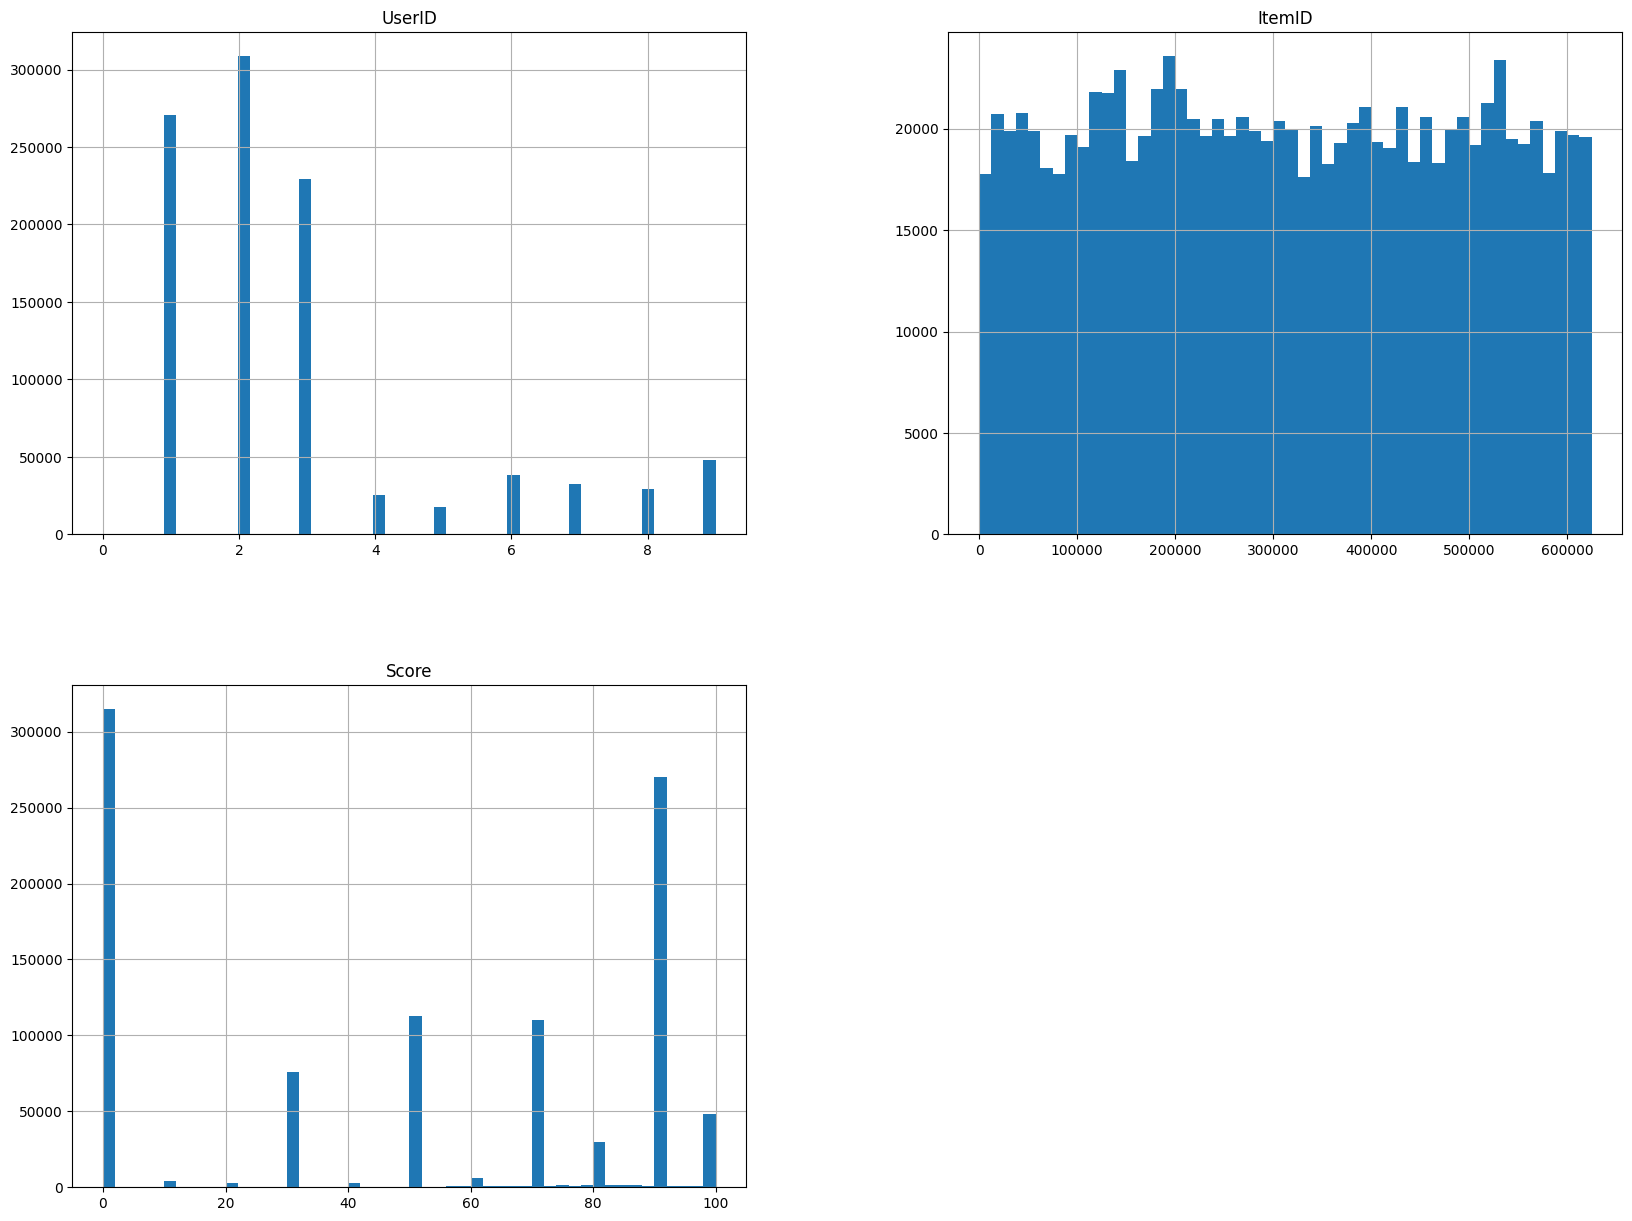

In [22]:
df.hist(bins=50, figsize=(20,15))
plt.show()

In [23]:
merged_df['Score'].value_counts()

0.0     127248
90.0    111451
70.0     61101
50.0     57720
30.0     34466
         ...  
14.0        31
31.0        30
9.0         21
2.0         21
3.0         16
Name: Score, Length: 101, dtype: int64

In [24]:
# round the scores to the nearest 10 and multiply by 10 to get the rounded value
merged_df['rounded_score'] = round(merged_df['Score'] / 10) * 10

In [25]:
merged_df.head()

,UserID,ItemID,Score,TrackID,AlbumID,ArtistID,GenreID,rounded_score
26,0.0,127640.0,50.0,127640.0,113323.0,592747.0,85012.0,50.0
30,0.0,193714.0,30.0,193714.0,26137.0,180037.0,531386.0,30.0
32,0.0,522229.0,0.0,522229.0,94522.0,452599.0,600770.0,0.0
34,0.0,112040.0,90.0,112040.0,450906.0,392726.0,600770.0,90.0
37,0.0,464229.0,90.0,464229.0,453488.0,9101.0,600770.0,90.0


In [26]:
merged_df['rounded_score'].value_counts()

0.0      127451
90.0     114834
70.0      63299
50.0      58401
30.0      34988
100.0     30402
80.0      11198
60.0       5511
40.0       1998
20.0       1707
10.0       1683
Name: rounded_score, dtype: int64

In [27]:
merged_df['rounded_score'].value_counts().mean()

41042.90909090909

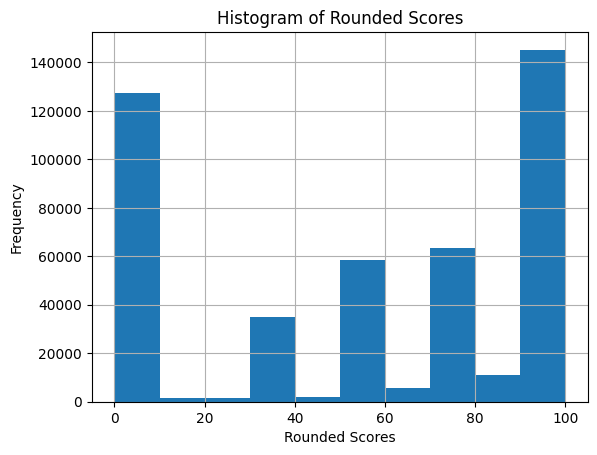

In [28]:
# plot a histogram of the 'scores' column
merged_df['rounded_score'].hist()

# add axis labels and a title
plt.xlabel('Rounded Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Rounded Scores')
plt.show()

In [29]:
merged_df['rounded_score'].describe()

count    451472.000000
mean         51.239656
std          37.416180
min           0.000000
25%           0.000000
50%          50.000000
75%          90.000000
max         100.000000
Name: rounded_score, dtype: float64

In [30]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy='not majority')
X_resampled, y_resampled = ros.fit_resample(merged_df.drop('rounded_score', axis=1), merged_df['rounded_score'])
resampled_df = pd.concat([X_resampled, y_resampled], axis=1)


In [31]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='not minority')
X_under_sampled, y_under_sampled = rus.fit_resample(merged_df.drop('rounded_score', axis=1), merged_df['rounded_score'])
undersampled_df = pd.concat([X_under_sampled, y_under_sampled], axis=1)


In [32]:
resampled_df['rounded_score'].value_counts()

50.0     127451
30.0     127451
0.0      127451
90.0     127451
100.0    127451
70.0     127451
80.0     127451
40.0     127451
10.0     127451
60.0     127451
20.0     127451
Name: rounded_score, dtype: int64

In [33]:
undersampled_df['rounded_score'].value_counts()

0.0      1683
10.0     1683
20.0     1683
30.0     1683
40.0     1683
50.0     1683
60.0     1683
70.0     1683
80.0     1683
90.0     1683
100.0    1683
Name: rounded_score, dtype: int64

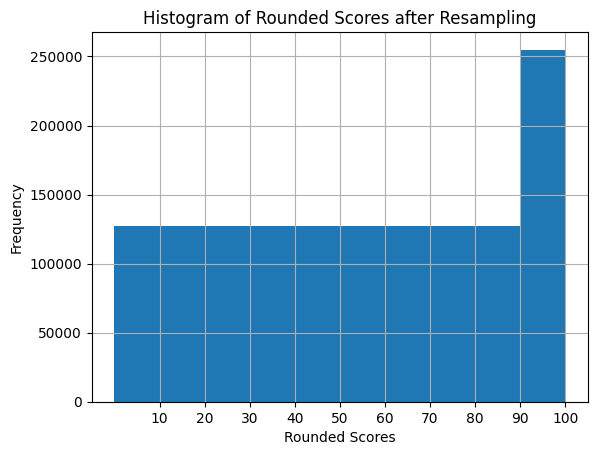

In [34]:
# set the desired tick locations
tick_locations = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# plot a histogram of the 'scores' column with the specified tick locations
resampled_df['rounded_score'].hist(bins=10)
plt.xticks(tick_locations)

# add axis labels and a title
plt.xlabel('Rounded Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Rounded Scores after Resampling')

plt.show()

In [35]:
resampled_df.columns

Index(['UserID', 'ItemID', 'Score', 'TrackID', 'AlbumID', 'ArtistID',
       'GenreID', 'rounded_score'],
      dtype='object')

In [36]:
# X = undersampled_df[['UserID', 'ItemID', 'TrackID', 'GenreID', 'ArtistID', 'AlbumID']]
# y = undersampled_df['rounded_score']

In [37]:
X = resampled_df[['UserID', 'ItemID', 'TrackID', 'GenreID', 'ArtistID', 'AlbumID']]
y = resampled_df['rounded_score']

In [38]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_X = scaler.fit_transform(X)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.2, stratify=y, random_state=1337)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=1337)

In [40]:
print(f"Train Set dimensions: X Train: {X_train.shape}, Y Train: {y_train.shape}")
print(f"Validation Set dimensions: X Validation: {X_val.shape}, Y Validation: {y_val.shape}")
print(f"Test Set dimensions: X Test {X_test.shape}, Y Test: {y_test.shape}")

Train Set dimensions: X Train: (841176, 6), Y Train: (841176,)
Validation Set dimensions: X Validation: (280392, 6), Y Validation: (280392,)
Test Set dimensions: X Test (280393, 6), Y Test: (280393,)


In [41]:
type(X_train)

numpy.ndarray

In [42]:
# # Load the data into Numpy arrays
# X_train = np.array(X_train.iloc[:, [0, 1, 2, 3, 4, 5]])
# X_val = np.array(X_val.iloc[:, [0,1,2,3,4,5]])
y_train = np.array(y_train)
y_val = np.array(y_val)
X_test = np.array(X_test)

In [43]:
# Reshape the input data for the LSTM model
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [44]:
# Reshape the input data to a 3D tensor
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[2]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[2]))


In [45]:
# Define the model architecture
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(1, 6), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 32)             4992      
                                                                 
 dropout (Dropout)           (None, 1, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 13,345
Trainable params: 13,345
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Compile the model
model.compile(loss='mean_squared_logarithmic_error', optimizer=Adam(learning_rate=0.001), 
              metrics=[metrics.mean_squared_logarithmic_error, 
                       metrics.mean_absolute_error,
                       metrics.mean_absolute_percentage_error])

In [48]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=10)

Epoch 1/10
26287/26287 [==============================] - 159s 6ms/step - loss: 1.6983 - mean_squared_logarithmic_error: 1.6983 - mean_absolute_error: 30.6499 - mean_absolute_percentage_error: 2904914176.0000 - val_loss: 1.6298 - val_mean_squared_logarithmic_error: 1.6298 - val_mean_absolute_error: 30.1889 - val_mean_absolute_percentage_error: 2961824768.0000
Epoch 2/10
26287/26287 [==============================] - 149s 6ms/step - loss: 1.6402 - mean_squared_logarithmic_error: 1.6402 - mean_absolute_error: 30.4680 - mean_absolute_percentage_error: 2905897728.0000 - val_loss: 1.6289 - val_mean_squared_logarithmic_error: 1.6289 - val_mean_absolute_error: 30.1098 - val_mean_absolute_percentage_error: 2979133440.0000
Epoch 3/10
26287/26287 [==============================] - 144s 5ms/step - loss: 1.6368 - mean_squared_logarithmic_error: 1.6368 - mean_absolute_error: 30.4315 - mean_absolute_percentage_error: 2902953728.0000 - val_loss: 1.6273 - val_mean_squared_logarithmic_error: 1.6273 - v

In [1]:
import matplotlib.pyplot as plt

# Retrieve the metrics from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_msle = history.history['mean_squared_logarithmic_error']
val_msle = history.history['val_mean_squared_logarithmic_error']
train_mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
train_mape = history.history['mean_absolute_percentage_error']
val_mape = history.history['val_mean_absolute_percentage_error']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the training and validation mean squared logarithmic error
plt.plot(train_msle, label='Training MSLE')
plt.plot(val_msle, label='Validation MSLE')
plt.legend()
plt.title('Training and Validation MSLE')
plt.xlabel('Epoch')
plt.ylabel('MSLE')
plt.show()

# Plot the training and validation mean absolute error
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend()
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

# Plot the training and validation mean absolute percentage error
plt.plot(train_mape, label='Training MAPE')
plt.plot(val_mape, label='Validation MAPE')
plt.legend()
plt.title('Training and Validation MAPE')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.show()


NameError: ignored

In [50]:
y_pred = model.predict(X_test)

8763/8763 [==============================] - 18s 2ms/step


In [ ]:
# calculate RMSE and MAE
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
mae = metrics.mean_absolute_error(y_test, y_pred)

print('RMSE:', rmse)
print('MAE:', mae)